In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import prospect.io.read_results as pread
import corner
from corner import quantile
from hyperion.model import ModelOutput
import astropy.units as u
import astropy.constants as constants
import matplotlib
matplotlib.rcParams.update({
    "savefig.facecolor": "w",
    "figure.facecolor" : 'w',
    "figure.figsize" : (10,8),
    "text.color": "k",
    "legend.fontsize" : 20,
    "font.size" : 30,
    "axes.edgecolor": "k",
    "axes.labelcolor": "k",
    "axes.linewidth": 3,
    "xtick.color": "k",
    "ytick.color": "k",
    "xtick.labelsize" : 25,
    "ytick.labelsize" : 25,
    "ytick.major.size" : 12,
    "xtick.major.size" : 12,
    "ytick.major.width" : 2,
    "xtick.major.width" : 2,
    "font.family": "STIXGeneral",
    "mathtext.fontset" : "cm",
    #"legend.title_fontsize": 20
})

def get_best(res, **kwargs):
    imax = np.argmax(res['lnprobability'])
    theta_best = res['chain'][imax, :].copy()

    return theta_best

def find_nearest(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    return idx


## Let's model attenuation curves!

Here I'll walk through how to process the output from Prospector, specifically to get the estimated attenution curve. I'll show two example models. These results are going to come from my analysis in Lower et al. 2022. The first attenuation curve model is the parameterization of Kriek & Conroy 2013 (fsps option 4). The second is also the Kriek & Conroy model but with an extra parameter called f_unobscured. The basic idea is that this parameter allows a nonzero fraction of stellar light be unobscured from dust. I'll call the first model "uniform screen' and the second model 'nonuniform screen.' The first model is super easy to process since we can just plug the model posteriors into the equation. The second model requires a bit more legwork, but I'll explain that when we get there. 

In [3]:
res, obs, mod = pread.results_from('uniform_screen_fit.h5')

#lol ignore these messages

uniform doesn't work for some reason?
building model


In [71]:
def calzetti(wave,**kwargs):
    #via fsps
    dd63=6300.00
    lamv=3000.0
    dlam=350.0
    lamuvb=2175.0
    w63   = find_nearest(wave,dd63)
    cal00 = np.zeros(len(wave))
    cal00[w63:] = 1.17*( -1.857+1.04*(1e4/wave[w63:])) + 1.78
    cal00[:w63]  = 1.17*(-2.156+1.509*(1e4/wave[0:w63]))-0.198*(1e4/wave[:w63])**2 + 0.011*(1e4/wave[:w63])**3 + 1.78
    cal00 = cal00/0.44/4.05  #R_V=4.05
    return cal00

def kriek_and_conroy_attenuation(wave, dust2, dust_index):
    #code ripped from fsps
    dd63=6300.00
    lamv=3000.0
    dlam=350.0
    lamuvb=2175.0
    attn_curve=[]
    calz = calzetti(wave)
    for av,delta in zip(dust2, dust_index):
        eb = 0.85 - 1.9 * delta  #KC13 Eqn 3
        #Drude profile for 2175A bump
        drude = eb*(wave*dlam)**2 / ( (wave**2-lamuvb**2)**2 + (wave*dlam)**2 )
        attn_curve.append(av*(calz+drude/4.05)*(wave/lamv)**delta)
    return attn_curve

In [72]:
#get relevant posteriors, but we'll only sample the first 5000 most likely values
params = mod.theta_labels()
weights = res.get('weights',None) #likelihood values
idx = np.argsort(weights)[-5000:]
dust2 = res['chain'][idx,params.index('dust2')]
dust_index = res['chain'][idx, params.index('dust_index')]

#and define a wavelength array
wave = np.linspace(0.1, 1, 100) #micron

In [73]:
attn_curve_chain = kriek_and_conroy_attenuation(wave*1e4,dust2, dust_index) #expects wavelength in Angstrom

In [81]:
#now calculate 16th-84th quantiles, basically getting the 1sigma spread of the posterior

uniform_screen_curves50 = []
uniform_screen_curves16 = []
uniform_screen_curves84 = []

for i in range(len(wave)):
    attn_quantiles = quantile([item[i] for item in attn_curve_chain], [.16, .5, .84])
    uniform_screen_curves50.append(attn_quantiles[1])
    uniform_screen_curves16.append(attn_quantiles[0])
    uniform_screen_curves84.append(attn_quantiles[2])

Text(0.5, 0, 'wavelength [$\\mu$m]')

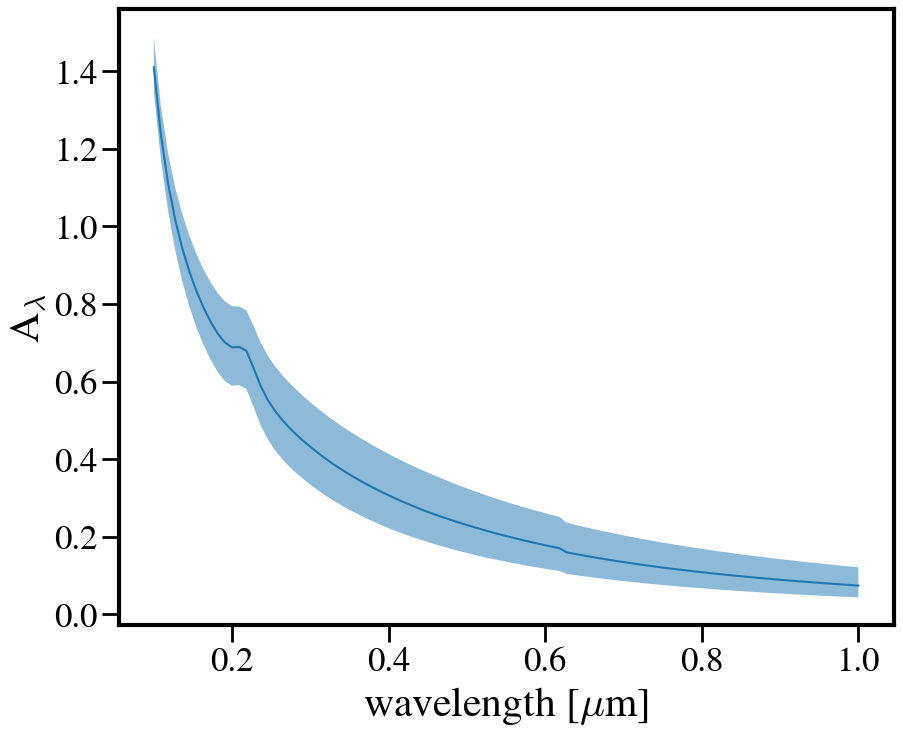

In [82]:
plt.fill_between(wave, uniform_screen_curves16, uniform_screen_curves84, alpha=0.5)
plt.plot(wave, uniform_screen_curves50)

plt.ylabel('A$_{\lambda}$')
plt.xlabel('wavelength [$\mu$m]')

Alright, now let's take a look at how to calculate the model attenuation curve for the nonuniform screen model.

In [86]:
res, obs, mod = pread.results_from('nonuniform_screen_fit.h5')
model_params = mod.theta_labels()
sps = pread.get_sps(res)

uniform doesn't work for some reason?
building model
uniform doesn't work for some reason?


The main difference here is that we can't only plug in the parameter values into an equation. The way this model works is that the attenuation curve is applied to the stellar spectrum, but some of the stellar light is left unattenuated. So we need to generate the model SED and the intrinsic stellar SED to get the attenuation curve ourselves. In other words, the Kriek and Conroy model is the attenuation curve, but the *effective* attenuation curve includes the contribution of unobscured stellar light. Here's how we'll treat it.

In [90]:
from tqdm.auto import tqdm
attn_curve_chain=[]
weights = res.get('weights',None) #likelihood values
idx = np.argsort(weights)[-5000:]
for params in tqdm(res['chain'][idx]):
    model_sed = mod.predict(params, obs, sps)
    #below we get the dust unobscured SED, i.e. just the stars, by setting dust2 (Av) == 0
    intrinsic_stellar_sed = mod.predict([0 if x == params[model_params.index('dust2')] else x for x in params], obs, sps)
    model_curve = np.array(-1.0*np.log(model_sed[0] / intrinsic_stellar_sed[0]) * 1.086)
    #and just downsample
    attn_curve_chain.append(np.interp(wave, sps.wavelengths/1e4, model_curve))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [91]:
#now calculate 16th-84th quantiles, basically getting the 1sigma spread of the posterior

nonuniform_screen_curves50 = []
nonuniform_screen_curves16 = []
nonuniform_screen_curves84 = []

for i in range(len(wave)):
    attn_quantiles = quantile([item[i] for item in attn_curve_chain], [.16, .5, .84])
    nonuniform_screen_curves50.append(attn_quantiles[1])
    nonuniform_screen_curves16.append(attn_quantiles[0])
    nonuniform_screen_curves84.append(attn_quantiles[2])

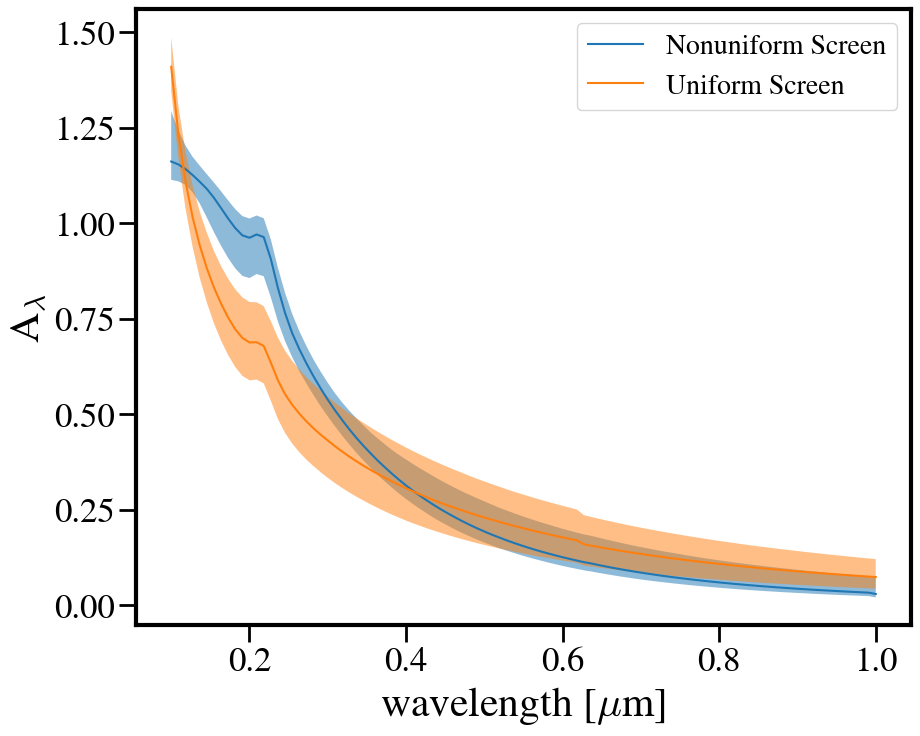

In [93]:
plt.fill_between(wave, nonuniform_screen_curves16, nonuniform_screen_curves84, alpha=0.5)
plt.plot(wave, nonuniform_screen_curves50, label='Nonuniform Screen')

plt.fill_between(wave, uniform_screen_curves16, uniform_screen_curves84, alpha=0.5)
plt.plot(wave, uniform_screen_curves50, label='Uniform Screen')

plt.ylabel('A$_{\lambda}$')
plt.xlabel('wavelength [$\mu$m]')
plt.legend()